In [62]:
import math
import random
import pandas as pd
import matplotlib.pyplot as plt 

In [63]:
df1 = pd.read_csv('TSPA.csv', header = None, sep = ';')
df2 = pd.read_csv('TSPB.csv', header = None, sep = ';')
df3 = pd.read_csv('TSPC.csv', header = None, sep = ';')
df4 = pd.read_csv('TSPD.csv', header = None, sep = ';')

In [64]:
df1

,0,1,2
0,1510,353,84
1,3042,123,483
2,2145,389,1462
3,1030,365,1986
4,2125,360,145
...,...,...,...
195,1023,1258,197
196,3192,1271,1183
197,3735,1879,1461
198,3983,299,1309


### Distance matrix
Node costs included

In [65]:
def calculate_distance(city1, city2):
    return math.ceil(math.sqrt((city1[0]-city2[0])**2 + (city1[1]-city2[1])**2))

In [66]:
def create_distance_matrix(df):
    distance_matrix = [[df.iloc[j, 2] for j in range(df.shape[0])] for i in range(df.shape[0])]
    for i in range(df.shape[0]):
        for j in range(df.shape[0]):
            if i == j:
                break
            dist = calculate_distance(df.values[i][:2], df.values[j][:2])
            distance_matrix[i][j] += dist
            distance_matrix[j][i] += dist
    return distance_matrix

### Helpful debugging function for checking the length of the cycle

In [67]:
def check_cycle_length(df, path):
    distance_matrix = create_distance_matrix(df)
    dist = 0
    for index, node in enumerate(path[:-1]):
        dist += distance_matrix[node][path[(index+1) % len(path)]]
    dist += distance_matrix[path[-1]][path[0]]
    return dist

### Random Solution

In [68]:
def random_TSP(cost_matrix):
    path = random.sample(range(0, len(cost_matrix)), math.ceil(len(cost_matrix) / 2))
    dist = 0
    for index, item in enumerate(path):
        dist += cost_matrix[item][path[(index+1) % len(path)]]
    return dist, path

### Nearest Neighbour

In [69]:
def nearest_TSP(cost_matrix, starting_city):
    dist = 0
    path = [starting_city]

    cycle_length = math.ceil(len(cost_matrix) / 2)

    for i in range(0, cycle_length - 1):
        shortest_distance = math.inf
        shortest_city = -1

        for j in range(len(cost_matrix)):
            if j in path:
                continue
            if cost_matrix[path[-1]][j] < shortest_distance:
                shortest_distance = cost_matrix[path[-1]][j]
                shortest_city = j
        
        path.append(shortest_city)
        dist += shortest_distance

    dist += cost_matrix[path[-1]][starting_city]

    return dist, path

### Greedy Cycle

In [70]:
def greedy_TSP(cost_matrix, starting_city):
    dist = 0
    path = [starting_city]

    cycle_length = math.ceil(len(cost_matrix) / 2)

    shortest_distance = math.inf
    shortest_city = -1

    for j in range(len(cost_matrix)):
        if j in path:
            continue
        if cost_matrix[path[-1]][j] < shortest_distance:
            shortest_distance = cost_matrix[path[-1]][j]
            shortest_city = j
    
    path.append(shortest_city)
    dist += shortest_distance
    dist += cost_matrix[path[-1]][starting_city]

    for i in range(0, cycle_length - 2):
        shortest_extra_distance = math.inf
        shortest_city = -1
        shortest_city_index = -1

        for j in range(len(cost_matrix)):
            if j in path:
                continue
            
            for k in range(len(path)):
                extra_distance = cost_matrix[path[k]][j] + cost_matrix[j][path[(k+1) % len(path)]] - cost_matrix[path[k]][path[(k+1) % len(path)]]
                if extra_distance < shortest_extra_distance:
                    shortest_extra_distance = extra_distance
                    shortest_city = j
                    shortest_city_index = k+1
            
        
        path.insert(shortest_city_index, shortest_city)
        dist += shortest_extra_distance
    


    return dist, path

### Compare methods

In [71]:
iterations = 200 ### change hardcode to matrix size
nearest_bests = []
greedy_bests = []
nearest_best_paths = []
greedy_best_paths = []

for id, df in enumerate([df1, df2, df3, df4]):
    distance_matrix = create_distance_matrix(df)

    print(f'\n==============[Dataset {id+1}]==============')
    print(f'RANDOM TSP')

    min_dist = math.inf
    max_dist = 0
    avg_dist = 0
    best_path = []

    for i in range(0, iterations):
        dist, path = random_TSP(distance_matrix)
        avg_dist += dist

        if dist < min_dist:
            min_dist = dist
            best_path = path
        elif dist > max_dist:
            max_dist = dist
    
    avg_dist /= iterations

    print(f'Best solution: {best_path}')
    print(f'Shortest distance: {min_dist}')
    print(f'Longest distance: {max_dist}')
    print(f'Average distance: {avg_dist}')

    print(f'\nNEAREST NEIGHBOUR TSP')

    min_dist = math.inf
    max_dist = 0
    avg_dist = 0
    best_path = []

    for i in range(0, iterations):
        dist, path = nearest_TSP(distance_matrix, i)
        avg_dist += dist

        if dist < min_dist:
            min_dist = dist
            best_path = path
        elif dist > max_dist:
            max_dist = dist
    
    avg_dist /= iterations

    assert check_cycle_length(df, best_path) == min_dist

    nearest_bests.append(min_dist)
    nearest_best_paths.append(best_path)

    print(f'Best solution: {best_path}')
    print(f'Shortest distance: {min_dist}')
    print(f'Longest distance: {max_dist}')
    print(f'Average distance: {avg_dist}')

    print(f'\nGREEDY CYCLE TSP')

    min_dist = math.inf
    max_dist = 0
    avg_dist = 0
    best_path = []

    for i in range(0, iterations):
        dist, path = greedy_TSP(distance_matrix, i)
        avg_dist += dist

        if dist < min_dist:
            min_dist = dist
            best_path = path
        elif dist > max_dist:
            max_dist = dist
    
    avg_dist /= iterations

    assert check_cycle_length(df, best_path) == min_dist

    greedy_bests.append(min_dist)
    greedy_best_paths.append(best_path)

    print(f'Best solution: {best_path}')
    print(f'Shortest distance: {min_dist}')
    print(f'Longest distance: {max_dist}')
    print(f'Average distance: {avg_dist}')


==============[Dataset 1]==============
RANDOM TSP
Best solution: [25, 164, 53, 120, 37, 159, 34, 88, 75, 187, 55, 44, 35, 134, 67, 157, 156, 142, 184, 23, 108, 194, 147, 171, 186, 141, 139, 155, 182, 189, 41, 12, 168, 19, 128, 178, 158, 143, 64, 185, 0, 162, 117, 29, 138, 104, 51, 39, 91, 81, 180, 28, 125, 45, 79, 98, 190, 90, 40, 72, 179, 177, 85, 137, 96, 176, 172, 58, 63, 166, 2, 126, 173, 199, 70, 165, 106, 122, 89, 195, 144, 43, 69, 119, 86, 102, 49, 8, 74, 192, 27, 145, 26, 131, 82, 61, 15, 110, 111, 127]
Shortest distance: 238468
Longest distance: 293987
Average distance: 265449.925

NEAREST NEIGHBOUR TSP
Best solution: [1, 177, 75, 189, 119, 48, 106, 11, 152, 130, 26, 8, 95, 169, 135, 167, 186, 79, 141, 6, 98, 66, 72, 94, 31, 80, 14, 111, 73, 112, 51, 190, 156, 172, 24, 87, 154, 81, 117, 55, 195, 74, 163, 113, 185, 96, 147, 59, 143, 178, 19, 0, 149, 114, 4, 77, 43, 50, 121, 91, 76, 22, 53, 62, 108, 171, 21, 194, 144, 102, 133, 180, 32, 132, 128, 164, 159, 27, 116, 64, 20, 71,

In [72]:
for i in range(4):
    print(f"df{i+1} Nearest {nearest_bests[i]}")

df1 Nearest 84524
df2 Nearest 77602
df3 Nearest 56352
df4 Nearest 50393


In [73]:
for i in range(4):
    print(f"df{i+1} Greedy {greedy_bests[i]}")

df1 Greedy 75726
df2 Greedy 68803
df3 Greedy 53527
df4 Greedy 50288


In [74]:
print(len(nearest_best_paths))
print(len(greedy_best_paths))

4
4


### Visualizations

In [75]:
def plot_cycle(df, cycle):
    plt.figure(figsize=(12, 9))

    # plotting the cycle  
    x = [df.values[i][0] for i in cycle]
    y = [df.values[i][1] for i in cycle]
    x.append(x[0])
    y.append(y[0])
    
    plt.plot(x, y, color='red', linestyle='dashed', linewidth = 2, 
            markerfacecolor='blue', markersize=6) 


    # plotting the points  
    x = [df.values[i][0] for i in range(df.shape[0])]
    y = [df.values[i][1] for i in range(df.shape[0])]
    size = [df.values[i][2] // 40 + 10 for i in range(df.shape[0])]

    plt.scatter(x, y, s=size)

    plt.xlim(0, 4000) 
    plt.ylim(0, 2000) 
    
    plt.title('Example path') 
    plt.xlabel('x - axis') 
    plt.ylabel('y - axis') 
    
    plt.show() 


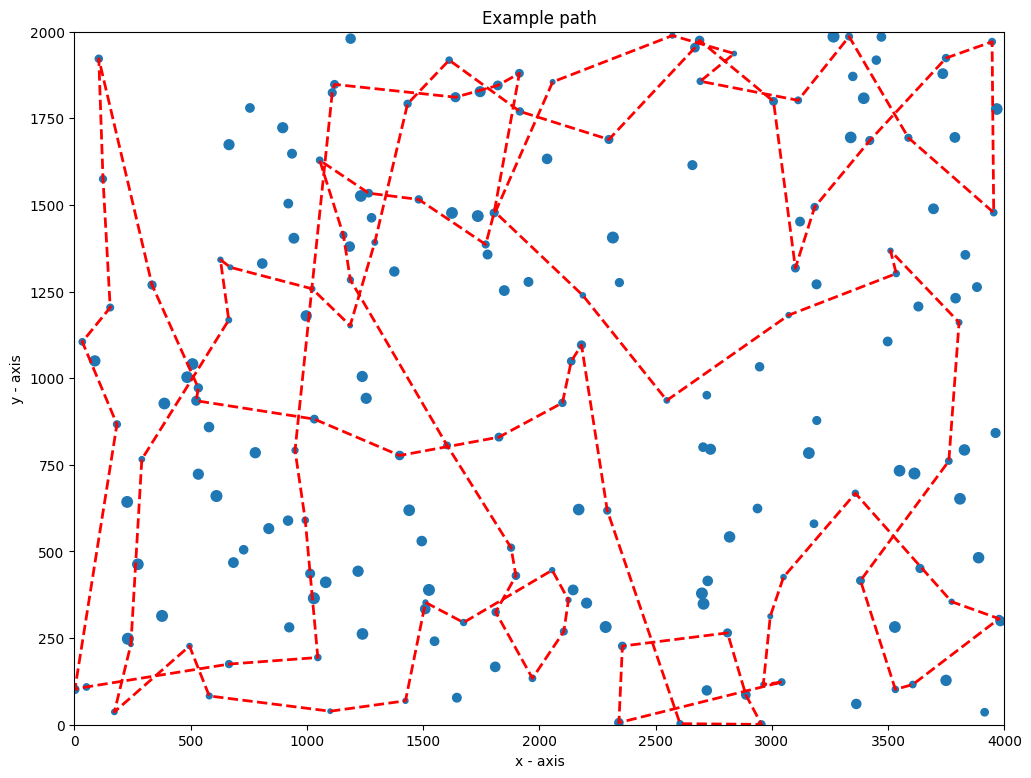

In [76]:
plot_cycle(df1, nearest_best_paths[0])

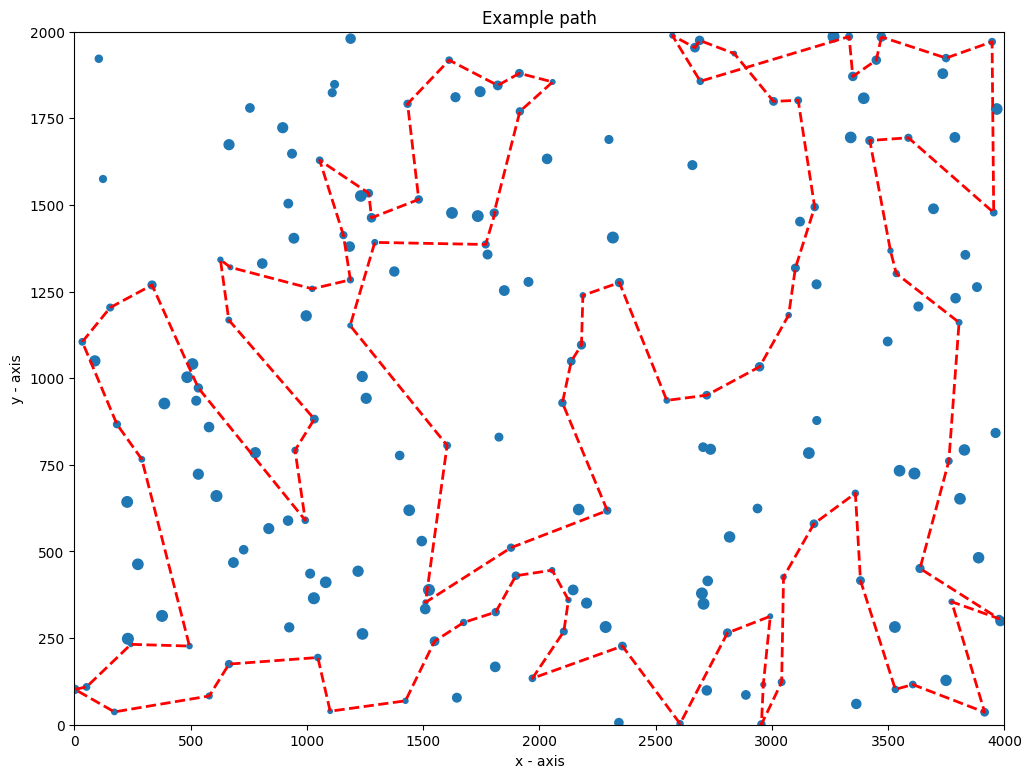

In [77]:
plot_cycle(df1, greedy_best_paths[0])